# Quantum Counting

This algorithm is a combination of the Quantum Phase Estimation(QPE) and the Grover algorithm, where the QPE is used to find eigenvalues of the Grover Operator and estimate how many solutions there are on the search space.

# 1) Algorithm

Grover's Algorithm works by rotating the superposition vector on the space of $\left| \beta \right>$ and $\left| \alpha \right>$, where the former is the the sum over all possible solutions to the problem and the latter is the sum over all that are not solutions. The Grover Operator is the following: 

$$
G = \begin{bmatrix}
cos \theta & -sin \theta \\
sin \theta & cos \theta 
\end{bmatrix}
$$

Thus we can use the QPE of the Grover Operator to find how many solutions there are on the problem. This operator has eigenvalues of $e^{i \theta}$ and $e^{2 i  \pi - i \theta} = e^{-i \theta}$, so we can estimate $\theta$ using QPE.


# 2) Example

In order to understand this algorithm is to do a problem which we know how many solutions there are for the search problem and see it come up by this algorithm.

Let's consider the problem of solving the following search problem: We have N=4 and the solution is the state $\left| 11 \right>$. Thus, we have the following Grover Operator.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import qiskit as qsk 

## 2.1) Defining the Grover Operator

In [2]:
def grover_operator():
    qc = qsk.QuantumCircuit(2)
    qc.cz(0,1);
    qc.h(range(2));
    qc.z(range(2));
    qc.cz(0,1);
    qc.h(range(2));
    return qc

Since we need to do the QPE of the Grover operator, we must transform it into a controlled gate, this is done by the following:

In [12]:
G = grover_operator()
backend = qsk.Aer.get_backend('unitary_simulator')
job = qsk.execute(G, backend)
result = job.result()
Unitary_G = result.get_unitary(G, decimals=3)
print(f'Grover Operator: \n {Unitary_G}')

Grover Operator: 
 [[-0.5+0.j  0.5-0.j  0.5-0.j -0.5+0.j]
 [ 0.5-0.j -0.5+0.j  0.5-0.j -0.5+0.j]
 [ 0.5-0.j  0.5-0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j  0.5-0.j  0.5-0.j  0.5-0.j]]


## 2.2) Quantum Phase Estimation of the Grover Operator

Now we apply the phase estimation for this operator. This circuit will estimate the eigenvalue $\theta$ with m bits of accuracy, with a probability of succes of at least $1 - \epsilon$, so the first register must have $ t \equiv m + \big \lceil log (2 + \frac{1}{2\epsilon}) \big\rceil $. 

Choosing $m = \big \lceil \frac{n}{2} \big\rceil + 1$ (where n corresponds to the number of qubits on the second register) an $\epsilon = \frac{1}{6}$, we have $ t = \big \lceil \frac{n}{2} \big\rceil + 3$, on this example we have $n=2$ therefore we have $t=4$.

Our accuracy is: $|\Delta M | < \sqrt{\frac{M}{2}} + \frac{1}{4}$. Then if the problem has $M=0$ we would have $|\Delta M | < \frac{1}{4}$, so the algorithm must produce the estimate with probability at least $\frac{5}{6}$. Otherwise, if $M \neq 0$ we see that the estimate for M is not equal to 0 at least $\frac{5}{6}$ times.

In [30]:
#Append path for Algorithms.py
import sys
sys.path.append('../')
from Algorithms import _qpe

n_ancilla = 2
n_precision = 4
qc = qsk.QuantumCircuit(n_precision+n_ancilla, n_precision)
QPE(qc, Unitary_G, n_precision, n_ancilla)
qc.measure(range(n_precision), range(n_precision))
qc.draw()

┌──────┐┌─┐         
q_0: ┤0     ├┤M├─────────
     │      │└╥┘┌─┐      
q_1: ┤1     ├─╫─┤M├──────
     │      │ ║ └╥┘┌─┐   
q_2: ┤2     ├─╫──╫─┤M├───
     │  QPE │ ║  ║ └╥┘┌─┐
q_3: ┤3     ├─╫──╫──╫─┤M├
     │      │ ║  ║  ║ └╥┘
q_4: ┤4     ├─╫──╫──╫──╫─
     │      │ ║  ║  ║  ║ 
q_5: ┤5     ├─╫──╫──╫──╫─
     └──────┘ ║  ║  ║  ║ 
c_0: ═════════╩══╬══╬══╬═
                 ║  ║  ║ 
c_1: ════════════╩══╬══╬═
                    ║  ║ 
c_2: ═══════════════╩══╬═
                       ║ 
c_3: ══════════════════╩═

Results of the QPE

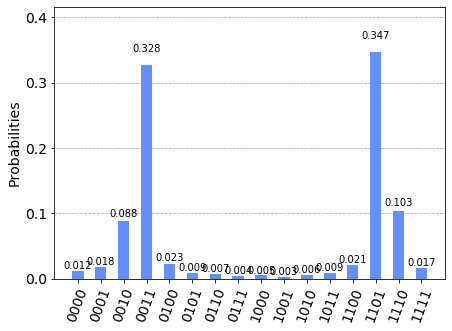

In [33]:
from qiskit.visualization import plot_histogram

emulator = qsk.Aer.get_backend('qasm_simulator')
job = qsk.execute(qc, emulator, shots=2048 )
hist = job.result().get_counts()
plot_histogram(hist)

## 2.3) Finding the number of solutions

The algorithm works as expected, we see two peaks that must correspond to the eigenvalues $\theta$ and $-\theta$. 
We can estimate M by using that $sin \frac{\theta}{2} = \sqrt{\frac{M}{N}}$, so we must get $\theta$ by the following equation:

$$
\theta = estimation * \frac{2 \pi}{2^t}
$$.

So knowing $\theta$ we estimate M by using the following equation:

$$
M = N \sin^2\frac{\theta}{2}
$$

In [54]:
from IPython.display import display, Markdown
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
theta = (measured_int/(2**n_precision))*np.pi*2
N = 2**n_ancilla
M = N * (np.sin(theta/2)**2)

display(Markdown(
   rf"""
Register String: ${measured_str}$

Register Integer: ${measured_int}$

$\theta$: ${theta:.3f}$

$M$ = {M:.3f}
"""))


Register String: $1101$

Register Integer: $13$

$\theta$: $5.105$

$M$ = 1.235


In this case we have the error given by 

$$
|\Delta M | < \sqrt{\frac{1.23}{2}} + \frac{1}{4} \approx 1.04
$$

-------------------------------------------------------------------------------------------------------------------------------------

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table